In [ ]:
from app.config import DATABASE_URL
DATABASE_URL

[*********************100%***********************]  3 of 3 completed
'NoneType' object has no attribute 'sum'


<AxesSubplot:>

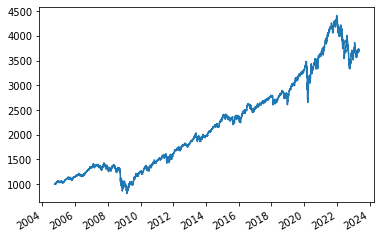

In [3]:
"""ROBERT"""
from typing import Optional, Callable
import pandas as pd
from app.core.analytics import metrics
from app.core.ext.clean import clean_weights


class AccountRecords:
    """virtual account records to store account records"""

    def __init__(self) -> None:
        self.value = {}
        self.shares = {}
        self.capitals = {}
        self.prices = {}
        self.weights = {}
        self.allocations = {}


class AccountMetrics:
    """virtual account metrics to store account metrics"""

    def __init__(self, initial_investment: float = 1000.0) -> None:
        self.value: float = initial_investment
        self.date: Optional[pd.Timestamp] = None
        self.shares: pd.Series = pd.Series(dtype=float)
        self.prices: pd.Series = pd.Series(dtype=float)
        self.capitals: pd.Series = pd.Series(dtype=float)
        self.weights: pd.Series = pd.Series(dtype=float)
        self.allocations: pd.Series = pd.Series(dtype=float)


class VirtualAccount:
    """virtual account to store account information"""

    def __init__(self, initial_investment: float = 1000.0) -> None:
        self.metrics = AccountMetrics(initial_investment)
        self.records = AccountRecords()

    ################################################################################
    @property
    def date(self) -> Optional[pd.Timestamp]:
        """account date property"""
        return self.metrics.date

    @date.setter
    def date(self, date: pd.Timestamp) -> None:
        """account date property"""
        self.metrics.date = date

    ################################################################################
    @property
    def value(self) -> float:
        """account value property"""
        return self.metrics.value

    @value.setter
    def value(self, value: float) -> None:
        """account value property"""
        self.metrics.value = value
        self.records.value.update({self.metrics.date: self.value})
        self.weights = self.capitals.divide(self.value)

    ################################################################################
    @property
    def prices(self) -> pd.Series:
        """account value property"""
        return self.metrics.prices

    @prices.setter
    def prices(self, prices: pd.Series) -> None:
        """account value property"""
        if not self.shares.empty:
            self.metrics.prices = prices
            self.records.prices.update({self.metrics.date: self.prices})
            self.capitals = self.shares.multiply(self.prices.fillna(0))

    ################################################################################
    @property
    def shares(self) -> pd.Series:
        """account shares property"""
        return self.metrics.shares

    @shares.setter
    def shares(self, shares: pd.Series) -> None:
        """account shares property"""
        self.metrics.shares = shares
        self.records.shares.update({self.metrics.date: self.shares})

    ################################################################################
    @property
    def capitals(self) -> pd.Series:
        """account capitals property"""
        return self.metrics.capitals

    @capitals.setter
    def capitals(self, capitals: pd.Series) -> None:
        """account capitals property"""
        self.metrics.capitals = capitals
        self.records.capitals.update({self.metrics.date: self.capitals})
        self.value = self.capitals.sum()

    ################################################################################
    @property
    def weights(self) -> pd.Series:
        """account weights property"""
        return self.metrics.weights

    @weights.setter
    def weights(self, weights: pd.Series) -> None:
        """account weights property"""
        self.metrics.weights = weights
        self.records.weights.update({self.metrics.date: self.weights})

    ################################################################################
    @property
    def allocations(self) -> pd.Series:
        """account allocations property"""
        return self.metrics.allocations

    @allocations.setter
    def allocations(self, allocations: pd.Series) -> None:
        """account allocations property"""
        if allocations is not None:
            self.metrics.allocations = allocations
            self.records.allocations.update({self.metrics.date: self.allocations})

    def reset_allocations(self) -> None:
        """reset allocations"""
        self.metrics.allocations = pd.Series(dtype=float)


class Strategy:
    """base strategy"""

    def __init__(
        self,
        prices: pd.DataFrame,
        rebalance: Callable,
        frequency: str = "M",
        initial_investment: float = 1000.0,
        min_periods: int = 2,
        min_assets: int = 2,
    ) -> None:
        self.account = VirtualAccount(initial_investment=initial_investment)
        self.prices = prices.ffill()
        self.rebalance = rebalance
        self.frequency = frequency
        self.min_periods = min_periods
        self.min_assets = min_assets

    @property
    def date(self) -> Optional[pd.Timestamp]:
        """date property"""
        return self.account.date

    @date.setter
    def date(self, date: pd.Timestamp) -> None:
        """date property"""
        if date in self.prices.index:
            self.account.date = date
            self.account.prices = self.prices.loc[self.date]

    @property
    def reb_prices(self) -> Optional[pd.DataFrame]:
        """rebalancing prices"""
        reb_prices = self.prices.loc[: self.date].copy()
        reb_prices.dropna(thresh=self.min_periods, axis=1, inplace=True)
        if len(reb_prices) < self.min_assets:
            return None
        if len(reb_prices.columns) < self.min_assets:
            return None
        return reb_prices

    ################################################################################

    @property
    def value(self) -> pd.Series:
        """strategy value time-series"""
        val = pd.Series(
            data=self.account.records.value, name="value", dtype=float
        ).sort_index()
        return val

    @property
    def weights(self) -> pd.DataFrame:
        """strategy weights time-series"""
        return pd.DataFrame(
            data=self.account.records.weights, dtype=float
        ).T.sort_index()

    @property
    def capitals(self) -> pd.DataFrame:
        """strategy capitals time-series"""
        return pd.DataFrame(
            data=self.account.records.capitals, dtype=float
        ).T.sort_index()

    @property
    def allocations(self) -> pd.DataFrame:
        """strategy allocations time-series"""
        return pd.DataFrame(
            data=self.account.records.allocations, dtype=float
        ).T.sort_index()

    ################################################################################

    def simulate(
        self, start: Optional[str] = None, end: Optional[str] = None, **kwargs
    ) -> "Strategy":
        """simulate strategy"""

        start = start or str(self.prices.index[0])
        end = end or str(self.prices.index[-1])

        reb_dates = pd.date_range(start=start, end=end, freq=self.frequency)

        for self.date in pd.date_range(start=start, end=end):
            if not self.account.allocations.empty:
                self.account.weights = self.account.allocations
                self.account.capitals = self.account.value * self.account.weights
                self.account.shares = self.account.capitals.divide(
                    self.prices.loc[self.date].dropna()
                )
                self.account.reset_allocations()
            if self.date in reb_dates or self.account.shares.empty:
                try:
                    self.account.allocations = clean_weights(
                        weights=self.rebalance(strategy=self),
                        num_decimal=4,
                    )
                except Exception as exc:
                    print(exc)
        return self

    def analytics(self) -> pd.DataFrame:
        """analytics"""

        __metrics__ = [
            metrics.to_ann_return,
            metrics.to_ann_volatility,
            metrics.to_sharpe_ratio,
            metrics.to_skewness,
            metrics.to_kurtosis,
            metrics.to_value_at_risk,
            metrics.to_conditional_value_at_risk,
        ]

        result = [metric(self.value.to_frame()).to_frame() for metric in __metrics__]
        return pd.concat(result, axis=1).T


import yfinance as yf
from app.core.portfolios import Optimizer


def equal_weights(strategy: Strategy) -> Optional[pd.Series]:
    """Default rebalancing method"""
    reb_prices = strategy.reb_prices
    if reb_prices is None: return None
    return Optimizer.from_prices(prices=reb_prices).uniform_allocation()


prices = yf.download("SPY, IEF, VNQ")["Adj Close"].dropna()
strategy = Strategy(prices=prices, rebalance=equal_weights).simulate()
strategy.value.plot()


In [ ]:
from typing import Optional
import pandas as pd
import yfinance as yf
# from app.core.strategies import Strategy
from app.core.portfolios import Optimizer


def equal_weights(prices: pd.DataFrame, strategy: Strategy) -> Optional[pd.Series]:
    """Default rebalancing method"""
    return Optimizer.from_prices(prices=prices).uniform_allocation()

prices = yf.download("SPY, AGG")["Adj Close"].dropna()
strategy = Strategy(prices=prices, rebalance=equal_weights).simulate()
strategy.value.plot()

def dual_momentum(prices: pd.DataFrame, strategy: Strategy) -> Optional[pd.Series]:
    """

    Procedure:
    1. Detect market-regime by combining economic indicators with S&P 500's momentum and volatility.
    2. In bear markets, use a momentum strategy trading various debt instruments.
    3. In bull markets, use two momentum strategies: one trading sector ETFs, the other trading style-box ETFs
    * For each momentum strategy
    * create a benchmark through equal-weighting the traded assets determine
    * momentum relative to this benchmark use walk-forward optimization to
    * continually adjust the momentum filters

    """
    pass


def trend_following(prices: pd.DataFrame, strategy: Strategy) -> Optional[pd.Series]:
    """
    The idea behind market trends is simple: Stocks that have been rising (or falling) 
    in the past tend to continue growing (or falling) in the future.

    There are many methods of determining market trends. 
    Among the most widely used ones are trend filters based on moving averages. 
    For example, we can consider an asset to be trending up when trading above its 200-day moving average.
    It is important to note that trend is binary. Either an asset is trending or not.
    Alternatively, we could also say that assets are either trending up or trending down.
    The resulting strategies typically also have binary behavior, switching from risk-on to risk-off allocations. 
    An excellent example of a trend-following strategy is Keller's Lethargic Asset Allocation.
    
    Link: https://www.turingtrader.com/portfolios/keller-lethargic-asset-allocation/

    """
    pass


def momentum(prices: pd.DataFrame, strategy: Strategy) -> Optional[pd.Series]:
    """
    

    """
    pass



prices = yf.download("SPY, AGG")["Adj Close"].dropna()
strategy = Strategy(prices=prices, rebalance=equal_weights).simulate()
strategy.value.plot()


In [ ]:
from app.core.analytics import metrics
def analytics() -> pd.DataFrame:
    """analytics"""
    
    __metrics__ = [
        metrics.to_ann_return,
        metrics.to_ann_volatility,
        metrics.to_sharpe_ratio,
        metrics.to_skewness,
        metrics.to_kurtosis,
        metrics.to_value_at_risk,
        metrics.to_conditional_value_at_risk,
    ]
    
    result = [metric(strategy.value.to_frame()).to_frame() for metric in __metrics__]
    print(pd.concat(result, axis=1).round(4))

analytics()

In [ ]:
from app import database
import pandas as pd
from app import config

database.create_all()
database.models.Meta.insert(
    pd.read_excel(
        config.DATABASE_EXC, 
        sheet_name="tb_meta", 
        parse_dates=["inception_date"]
    )
)


In [ ]:
from app import database as db

# with db.engine.connect() as conn:
#     conn.execute(
#         f"CREATE VIEW tb_test AS SELECT * FROM tb_meta WHERE tb_meta.meta_type == 'Equity'"
#     )


with db.SessionContext() as session:
    
    result = session.execute("SELECT * FROM tb_test")
    
    print(result.fetchall())


In [ ]:
from app.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, QQQ, XLG, XLV, XLU, XLB")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate("2023-1-1")

strategy.value.plot()

In [ ]:
from typing import Optional
import pandas as pd
from app.core.strategies import Strategy
from app.core.analytics.features import momentum
from app.core.analytics.metrics import to_ann_volatility


class DualMomentum(Strategy):
    # Objective: balanced growth
    # Type: momentum strategy
    # Invests in: ETFs tracking stocks, bonds, real estate, and gold
    # Rebalancing schedule: monthly
    # Taxation: 50% short-term capital gains
    # Minimum account size: $5,000
    def rebalance(self) -> Optional[pd.Series]:
        single_weight = 1 / (len(self.reb_prices.columns) - 1)
        safe = to_ann_volatility(self.reb_prices.iloc[-252:]).idxmin()
        mome_1y = momentum(self.reb_prices, months=6).iloc[-1]
        safe_mome = mome_1y.loc[safe]
        weights = {}
        for asset in self.reb_prices:
            if asset == safe:
                continue
            if mome_1y.loc[asset] > safe_mome:
                weights.update({asset: single_weight})
            else:
                if safe in weights.keys():
                    weights.update({safe: weights[safe] + single_weight})
                else:
                    weights.update({safe: single_weight})
        return pd.Series(weights)


import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")["Adj Close"]

strategy = DualMomentum(prices=prices).simulate("2015-1-1")

strategy.value.plot()


In [ ]:
from app.core.portfolios import Optimizer
from app.core.strategies import Strategy

class MaxSharpe(Strategy):
    def rebalance(self):
        prices = self.reb_prices.iloc[-252:]
        opt = Optimizer.from_prices(prices)
        return opt.maximized_sharpe_ratio()

import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")["Adj Close"]

prices

In [ ]:
test = prices.copy()
test[~test.isnull()] = 1
test


In [ ]:
from app.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate()

strategy.value


In [ ]:
from src import database as db

with db.SessionContext() as session:

    for (source,) in session.query(db.models.Meta.source).distinct():

        print(source)
        if source == "YAHOO":
            import yfinance as yf
            for meta in (
                session.query(db.models.Meta).filter(db.models.Meta.source == source).all()
            ):
                data = yf.download(
                    tickers=meta.code, start="1980-1-1", progress=False, actions=True
                ).reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = (
                        data.dividends.divide(data.close.shift(1)).fillna(0)
                    )
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)

        elif source == "NAVER":
            import pandas_datareader as pdr
            for meta in (
                session.query(db.models.Meta).filter(db.models.Meta.source == source).all()
            ):
                data = pdr.DataReader(name=meta.code, data_source="naver", start="1980-1-1").astype(float)
                data = data.reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = (
                        data.dividends.divide(data.close.shift(1)).fillna(0)
                    )
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)
        else:
            data = None
        



In [ ]:
import pandas as pd

w = pd.read_clipboard(index_col="date")
r = w.stack().astype(float)
r = r.reset_index()
r.columns = ["date", "ticker", "weight"]
r = r[r.weight != 0.0]
r.to_clipboard()

In [ ]:
pd.to_datetime(pd.to_datetime("2022-2-1")).to_pydatetime()

In [ ]:
pd.read_excel(
    config.DATABASE_EXC, 
    sheet_name="tb_meta", 
    parse_dates=["inception_date"]
).sort_values("meta_id")

In [ ]:
import pandas_datareader as pdr
import pandas as pd
def leading_economic_indicator() -> pd.DataFrame:
    """
    Get raw data for leading economic indicator regime.
    """
    tickers = dict(USALOLITONOSTSAM="USLEI")
    data = pdr.DataReader(list(tickers.keys()), "fred", start="1900-01-01").resample("M").last()
    data = data.rename(columns=tickers)
    return data[['USLEI']]

leading_economic_indicator()

In [ ]:
from src.core import metrics


import pandas as pd
nav = pd.read_clipboard(index_col="date", parse_dates=True)
nav

In [ ]:
metrics.to_max_drawdown(nav).to_clipboard()

In [ ]:
(prices / prices.resample("D").last().ffill().shift(1, freq=pd.DateOffset(months=1))).dropna()


In [ ]:
prices.pct_change(21)

In [ ]:
import pandas as pd

pri_returns = prices.pct_change()
latest_date = pri_returns.index[-1]
start_date = latest_date + pd.DateOffset(years=5)
start_date

In [ ]:
from src import db


db.create_all()

In [ ]:
import pandas as pd

pr_date = prices.index[-1] - pd.DateOffset(years = 1)

prices.iloc[-1] / prices.iloc[prices.index.get_loc(pr_date)] - 1

In [ ]:
import pandas_datareader as pdr



price = pdr.DataReader("329200", "naver", start="2021-4-1")
price.to_csv("329200.csv")

In [ ]:
import json

import pandas as pd
from sec_api import QueryApi
from sec_api import ExtractorApi
from src.config import EDGAR_API

queryApi = QueryApi(api_key=EDGAR_API)

query = {
    "query": {
        "query_string": {
            "query": "ticker:TSLA",
        }
    },
    "from": "200",
    "size": "300",
    "sort": [{"filedAt": {"order": "desc"}}],
}

response = queryApi.get_filings(query)


metadata = pd.DataFrame.from_records(response["filings"])

print(metadata)


# extractorApi = ExtractorApi(EDGAR_API)


# sections_10_k = {
#     "1": "Business",
#     "1A": "Risk Factors",
#     "1B": "Unresolved Staff Comments",
#     "2": "Properties",
#     "3": "Legal Proceedings",
#     "4": "Mine Safety Disclosures",
#     "5": "Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities",
#     "6": "Selected Financial Data (prior to February 2021)",
#     "7": "Management’s Discussion and Analysis of Financial Condition and Results of Operations",
#     "7A": "Quantitative and Qualitative Disclosures about Market Risk",
#     "8": "Financial Statements and Supplementary Data",
#     "9": "Changes in and Disagreements with Accountants on Accounting and Financial Disclosure",
#     "9A": "Controls and Procedures",
#     "9B": "Other Information",
#     "10": "Directors, Executive Officers and Corporate Governance",
#     "11": "Executive Compensation",
#     "12": "Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters",
#     "13": "Certain Relationships and Related Transactions, and Director Independence",
#     "14": "Principal Accountant Fees and Services",
# }


# for id, f in enumerate(response["filings"]):
#     if f["formType"] == "10-K":
#         url_10k = f["linkToFilingDetails"]

#         out = {}

#         for sec, des in sections_10_k.items():
#             out[des] = extractorApi.get_section(url_10k, sec, "text")

#         filename = f"{id}.json"

#         with open(filename, "w") as f:
#             json.dump(out, f)


In [ ]:
metadata.to_csv(
    'test.csv'
)

In [ ]:
response['filings'][0]['linkToTxt']

In [ ]:


# 8-K example
url_8k = "https://www.sec.gov/Archives/edgar/data/66600/000149315222016468/form8-k.htm"

item_1_1_text = extractorApi.get_section(response['filings'][0]['linkToTxt'], "1-1", "text")
item_1_1_text

In [ ]:


stra = strategy.HierarchicalEqualRiskContribution(prices=prices).simulate(
    start="2015-1-1"
)
stra.value.plot()
# weights_bm = prices.notna().divide(prices.notna().sum(axis=1), axis=0)
# metrics.to_pri_return(prices=prices).multiply(weights_bm).sum(axis=1).loc["2015-1-1":].add(1).cumprod().multiply(1000).plot()
stra.analytics()

In [ ]:
from src import db


with db.SessionContext() as session:
    
    query = session.query(db.models.Meta)
    
    result = list(record.to_dict() for record in query.all())
    
print(result)

In [ ]:
import pandas as pd

pd.DataFrame(result)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create line chart trace
line_trace = go.Scatter(
    x=stra.value.index, y=stra.value.values, mode="lines", name=stra.value.name
)

# create stacked bar chart traces
bar_traces = []
for col in stra.allocations.columns:
    trace = go.Bar(x=stra.allocations.index, y=stra.allocations[col]*100, name=col)
    bar_traces.append(trace)

# create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# add line chart to the first subplot with its own legend
fig.add_trace(line_trace, row=1, col=1)
fig.update_traces(showlegend=True, row=1, col=1)

# add stacked bar chart to the second subplot with its own legend
for trace in bar_traces:
    fig.add_trace(trace, row=2, col=1)
    fig.update_traces(showlegend=True, row=2, col=1)

# update chart layout and style
fig.update_layout(
    title="My Beautiful Subplots",
    xaxis_title="Date",
    yaxis_title="Values",
    template="plotly_dark",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        x=0.5,
        y=1.2,
        orientation='h',
        xanchor='center',
        yanchor='bottom',
        bordercolor="white",
        borderwidth=1,
        bgcolor="white",
        font=dict(size=12),
    ),
    font=dict(family="Arial", size=12, color="black"),
    barmode="stack",
    # add legends for subplots
    annotations=[
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Line Chart</b>",
            font=dict(size=14),
            align="center",
        ),
        dict(
            x=0.5,
            y=0.6,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Stacked Bar Chart</b>",
            font=dict(size=14),
            align="center",
        ),
    ],
)

# show the chart
fig.show()


In [ ]:
from src.core.portfolios import Optimizer
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]
opt = Optimizer.from_prices(prices=prices)
opt.hierarchical_equal_risk_contribution()

In [ ]:
opt.hierarchical_risk_parity()

In [ ]:
opt.maximized_sharpe_ratio()